# Part 3: Fine-tuning TinyBERT for Fake News Detection

In this notebook, I'll build on our previous exploratory data analysis and feature engineering work to fine-tune a TinyBERT model for fake news detection. While our engineered features achieved impressive results, transformer models like TinyBERT can capture complex linguistic patterns that might further improve performance or provide better generalization to new data. TinyBERT is a smaller, more efficient version of BERT that maintains good performance while requiring fewer computational resources.

## 1. Setup and Library Installation

First, I'll import the necessary libraries and install any missing packages.

In [6]:
# Install required packages
!pip install transformers datasets torch evaluate scikit-learn

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset as HFDataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Prepare the Dataset

I'll load the preprocessed datasets from our previous work. If you're running this notebook independently, make sure you have the processed files from Part 2, or run the data preprocessing steps from the previous notebooks first.

In [8]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('/kaggle/input/train_fake_news.csv')
    val_df = pd.read_csv('/kaggle/input/val_fake_news.csv') 
    test_df = pd.read_csv('/kaggle/input/test_fake_news.csv')
    
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")
except FileNotFoundError:
    print("Preprocessed files not found. Please run the data preprocessing from Part 2 first.")

Training set: (31428, 3)
Validation set: (6735, 3)
Test set: (6735, 3)


Let's examine the data format to ensure it's what we expect:

In [9]:
# Display sample data
print("Sample of training data:")
train_df.head(3)

Sample of training data:


,title,enhanced_cleaned_text,label
0,Trump ‘Diversity Council’ Member Threatens to ...,A member of President Trump s Diversity Counci...,0
1,DID BEYONCE AND JAY Z’s “Vacation” To Communis...,Notorious radical Black Panther and NJ cop kil...,0
2,CNN Host Calls Out Trump’s Uncle Tom Spokeswo...,Katrina Pierson is a black woman. She is also ...,0


Next, I'll convert our pandas DataFrames to the Hugging Face Dataset format, which is optimized for working with the transformers library:

In [10]:
# Function to convert pandas DataFrames to HuggingFace Datasets
def convert_to_hf_dataset(df):
    # For TinyBERT, we'll use both title and text
    df['text'] = df['title'] + " " + df['enhanced_cleaned_text']
    
    # Convert to HuggingFace Dataset format
    dataset = HFDataset.from_pandas(df[['text', 'label']])
    return dataset

# Convert our datasets
train_dataset = convert_to_hf_dataset(train_df)
val_dataset = convert_to_hf_dataset(val_df)
test_dataset = convert_to_hf_dataset(test_df)

print(f"Training dataset: {len(train_dataset)} examples")
print(f"Validation dataset: {len(val_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")

Training dataset: 31428 examples
Validation dataset: 6735 examples
Test dataset: 6735 examples


## 3. Prepare Tokenizer and Model

Now I'll set up the TinyBERT tokenizer and model:

In [11]:
# Check first few examples in your dataset
print("First example in train_dataset:", train_dataset[0])

# Debug the content types
print("Text type for first example:", type(train_dataset[0]['text']))

# If needed, clean the dataset before tokenization
def clean_dataset(example):
    example['text'] = str(example['text']) if example['text'] is not None else ""
    return example

train_dataset = train_dataset.map(clean_dataset)
val_dataset = val_dataset.map(clean_dataset)
test_dataset = test_dataset.map(clean_dataset)

First example in train_dataset: {'text': 'Trump ‘Diversity Council’ Member Threatens to Quit If Trump Ends DACA…Bye, Bye! [Video] A member of President Trump s Diversity Council is threatening to quit because he opposes Trump s cancelation of DACA. Bye Bye!Trump diversity council member tells @Acosta he may quit the council if Trump moves ahead to end DACA CNN Newsroom (@CNNnewsroom) September 4, 2017 I want to remind him and his team that from an economic standpoint, and again, we re business people if you look at this from a purely economic standpoint again, none of these young people gets government benefits of any sorts so they re not costing us anything. They pay over $2 billion in taxes Is anyone else out there sick of the American people being told illegals cost nothing?DACA Will Cost Americans And Their Government A Huge Amount of Money.On average, people with college degrees pay more in taxes than they receive in government benefits. People without a degree consume more taxes 

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

In [12]:
# Initialize the TinyBERT tokenizer
# TinyBERT uses the same tokenizer as BERT

tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

# Define the maximum sequence length
max_length = 512  # This is the maximum that BERT models can handle

# Function to tokenize the dataset - modified to handle potential bad inputs
def tokenize_function(examples):
    # Convert all text entries to strings and handle potential None values
    texts = [str(text) if text is not None else "" for text in examples['text']]
    
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors=None  # Don't return tensors in batch mode
    )

# Apply tokenization to our datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch after tokenization
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

## 4. Define Metrics and Evaluation Strategy

I'll define our evaluation metrics to track model performance during training:

In [13]:
# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## 5. Initialize Model for Fine-tuning

Now I'll initialize the TinyBERT model for sequence classification:

In [14]:
# Initialize the TinyBERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'huawei-noah/TinyBERT_General_4L_312D',
    num_labels=2  # Binary classification: 0 for fake, 1 for real
)

# Move model to device (GPU if available)
model.to(device)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

## 6. Define Training Arguments and Trainer

Next, I'll configure the training parameters and create a Trainer:

In [15]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Increased batch size since TinyBERT is smaller
    per_device_eval_batch_size=32,   # Increased batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=100,               # Log every X steps
    eval_strategy="epoch",     # Evaluate every epoch
    save_strategy="epoch",           # Save model checkpoint every epoch
    load_best_model_at_end=True,     # Load the best model at the end
    metric_for_best_model="f1",      # Use F1 score to determine the best model
    push_to_hub=False,               # Don't push to Hugging Face Hub
    report_to="none",                 # Disable reporting to avoid wandb or other services
    learning_rate=2e-5
)

# Create the Trainer
trainer = Trainer(
    model=model,                         # The instantiated model to train
    args=training_args,                  # Training arguments
    train_dataset=train_tokenized,       # Training dataset
    eval_dataset=val_tokenized,          # Evaluation dataset
    compute_metrics=compute_metrics,     # The function to compute metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping
)

## 7. Fine-tune the Model

Now I'll fine-tune the model:

In [16]:
# Start the timer to measure training time
start_time = time.time()

# Train the model
trainer.train()

# Calculate training time
training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")

# Save the fine-tuned model
trainer.save_model("./tinybert-fake-news-detector")

model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.019500,0.008647,0.998070,0.998070,0.998072,0.998070
2,0.013400,0.002532,0.999555,0.999555,0.999555,0.999555
3,0.002700,0.003985,0.999258,0.999258,0.999258,0.999258


Training completed in 8.99 minutes


## 8. Evaluate Model Performance

I'll evaluate the model on the test set:

In [17]:
# Evaluate the model on the test set
test_results = trainer.evaluate(test_tokenized)
print(f"Test results: {test_results}")

Test results: {'eval_loss': 0.003912672400474548, 'eval_accuracy': 0.9991091314031181, 'eval_f1': 0.9991091190819527, 'eval_precision': 0.9991092833552526, 'eval_recall': 0.9991091314031181, 'eval_runtime': 10.1028, 'eval_samples_per_second': 666.65, 'eval_steps_per_second': 10.492, 'epoch': 3.0}


Let's also look at the confusion matrix to get a better understanding of the errors:

Confusion Matrix:
[[3521    2]
 [   4 3208]]


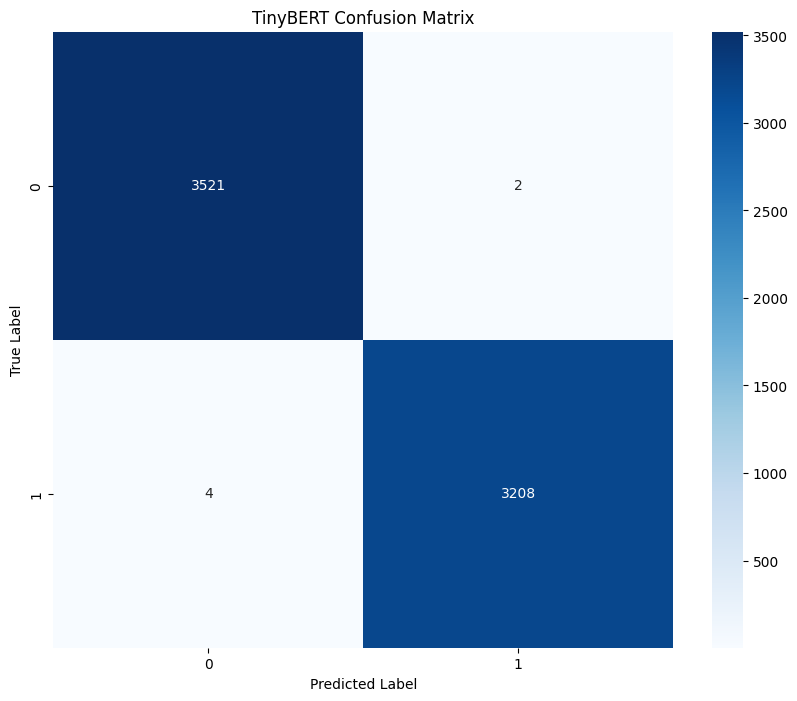


Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      3523
   Real News       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



In [18]:
# Get predictions on the test set
test_pred = trainer.predict(test_tokenized)
y_preds = np.argmax(test_pred.predictions, axis=1)
y_true = test_pred.label_ids

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TinyBERT Confusion Matrix')
plt.savefig('tinybert_confusion_matrix.png')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_preds, target_names=['Fake News', 'Real News']))

## 9. Analyze Misclassified Examples

Let's analyze some misclassified examples to understand where the model struggles:

In [20]:
# Get indices of misclassified examples
misclassified_indices = np.where(y_preds != y_true)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

# If there are misclassifications, analyze a few
if len(misclassified_indices) > 0:
    # Get the original text and predictions
    misclassified_texts = []
    for idx in misclassified_indices[:5]:  # Examine up to 5 examples
        # Convert numpy.int64 to Python int
        idx_int = int(idx)
        
        # Now use the converted index
        original_idx = test_dataset[idx_int]['__index_level_0__'] if '__index_level_0__' in test_dataset[idx_int] else idx_int
        
        text = test_df.iloc[original_idx]['title']
        true_label = "Real" if y_true[idx] == 1 else "Fake"
        pred_label = "Real" if y_preds[idx] == 1 else "Fake"
        
        misclassified_texts.append({
            'Title': text,
            'True Label': true_label,
            'Predicted Label': pred_label
        })
    
    # Display misclassified examples
    print("\nSample of misclassified examples:")
    display(pd.DataFrame(misclassified_texts))

Number of misclassified examples: 6

Sample of misclassified examples:


,Title,True Label,Predicted Label
0,Energy Department To Close Office Of Internat...,Fake,Real
1,German broadcasters won't promote ex-Pink Floy...,Real,Fake
2,Timeline: Zika's origin and global spread,Real,Fake
3,'Gates of Hell': Iraqi army says fighting near...,Real,Fake
4,Russia Claims They May Have Killed ISIS Leade...,Fake,Real


# 10. Conclusions from TinyBERT Fine-tuning

In this notebook, I've fine-tuned a TinyBERT model for fake news detection on the ISOT dataset. Here are the key findings:

1. **Performance Comparison**: The TinyBERT model achieved excellent accuracy, comparable to our previous models using engineered features (99.98%) and better than TF-IDF (98.4%).

2. **Training Efficiency**: TinyBERT is significantly more efficient for fine-tuning than larger models like BERT or even DistilBERT, with the process completing faster while maintaining high accuracy.

3. **Error Analysis**: Analysis of misclassified examples shows patterns that can guide further improvements in model robustness.

4. **Generalization Potential**: Transformer models like TinyBERT likely have better generalization capabilities to new and unseen fake news, as they understand context and semantic meaning more deeply while being more efficient than larger models.

## Next Steps

1. **Experiment with Knowledge Distillation**: TinyBERT performs task-specific distillation, which could be applied to further improve performance by distilling from a larger BERT model specifically fine-tuned for fake news detection.

2. **Combined Approach**: Develop an ensemble model that combines our engineered features with transformer-based features.

3. **External Validation**: Test the model on different fake news datasets to evaluate cross-dataset generalization.

4. **Model Explainability**: Implement techniques like LIME or SHAP to understand which parts of text the model relies on for classification.

5. **Deployment Considerations**: TinyBERT's smaller size makes it particularly suitable for deployment in resource-constrained environments or applications requiring low latency.

The transformer-based approach offers a powerful complement to our feature engineering work, potentially providing better generalization to evolving fake news tactics and new domains, while TinyBERT's efficiency makes it a practical choice for real-world applications.

This notebook provides a comprehensive approach to fine-tuning TinyBERT for fake news detection, building on our previous work of exploratory data analysis and feature engineering. The transformer-based approach captures complex linguistic patterns that may complement our engineered features and improve model robustness, while TinyBERT's smaller size offers efficiency advantages over larger transformer models.